In [1]:
# rm(list = ls(all.names = TRUE)) # will clear all objects
# gc() # free up memory and report the memory usage

library(tidyverse)
library(readxl)
library(openxlsx)
library(xts)
library(stringi)
library(lubridate)
library(dynlm)
library(vars)
library(plotly)
library(dplyr)
library(zoo)
library(ggplot2)
library(ggfortify)
library(ggpubr)

# start date of the data and end date for data and forecasting in the imported csv file (check the file first)
datestart.data <- "2020/1/22"   ### Start of past date
dateend.data <- "2021/10/06"      ### End of past date
datestart.fcst <- "2021/10/07"    ### Start of forecast date
dateend.fcst <- "2023/12/31"    ### End of forecast date
date.data <- seq(as.Date(datestart.data), as.Date(dateend.fcst),"days")
date.fcst <- seq(as.Date(datestart.fcst), as.Date(dateend.fcst),"days")
date.full <- seq(as.Date(datestart.data), as.Date(dateend.fcst),"days")

date.full.wd <- wday(date.full)

dd.Mon <- ifelse(date.full.wd==2, 1, 0)
dd.Tue <- ifelse(date.full.wd==3, 1, 0)
dd.Wed <- ifelse(date.full.wd==4, 1, 0)
dd.Thu <- ifelse(date.full.wd==5, 1, 0)
dd.Fri <- ifelse(date.full.wd==6, 1, 0)
dd.Sat <- ifelse(date.full.wd==7, 1, 0)
dd.Sun <- ifelse(date.full.wd==1, 1, 0)

setwd("/home/sysadm/Desktop/pogba_backup2/0. Gil_Prediction/02_code/SWAR/R/211102")
# Import the csv data
df <- read.csv("../../../../01_data/SWAR/swar_211102.csv")   #### Update csv file
df <- cbind(df,dd.Mon,dd.Tue,dd.Wed,dd.Thu,dd.Fri,dd.Sat,dd.Sun)
df <- df %>% 
  mutate(Confirmed.MA7 = rollmean(Confirmed, k = 7, fill = NA, align = "right")) %>%
  mutate(Deaths.MA7 = rollmean(Deaths, k = 7, fill = NA, align = "right")) %>%
  mutate(Severity.MA7 = rollmean(Severity, k = 7, fill = NA, align = "right")) 

# select the endogenous variables in y
y.df <- select(df,Confirmed.MA7)
y.xts <- as.xts(y.df, order.by = date.data)

# select the exogenous variables in x
x.df <- select(df,VM_alpha,VM_delta,d_Vaccine)
x.xts <- as.xts(x.df, order.by = date.data)

# select weekday dummies (excluding Sunday)
wd.df <- select(df,dd.Mon,dd.Tue,dd.Wed,dd.Thu,dd.Fri,dd.Sat)
wd.xts <- as.xts(wd.df, order.by = date.data)

# select social distance varaible
OX.df <- select(df,Ox)
OX.xts <- as.xts(OX.df, order.by = date.data)


# sample size and forecasting window
size.H <- length(date.fcst)         # forecasting window: in this case, the length of future values in x
size.T <- length(date.data)-size.H  # sample size for estimation

n <- ncol(y.df) # Number of endogenous variables (y) 
k <- ncol(x.df) # Number of exogenous variables (x) 




── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: strucc

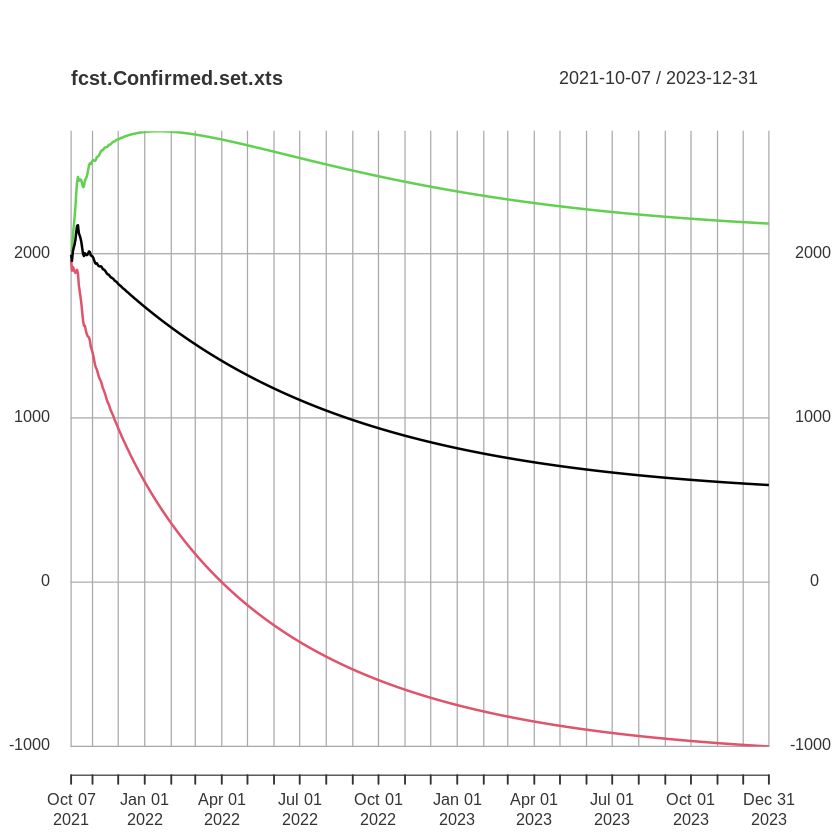

Warning message in arima(y.xts.est, order = c(opt.p3, 0, 2), xreg = AR.exog, include.mean = TRUE, :
“possible convergence problem: optim gave code = 1”


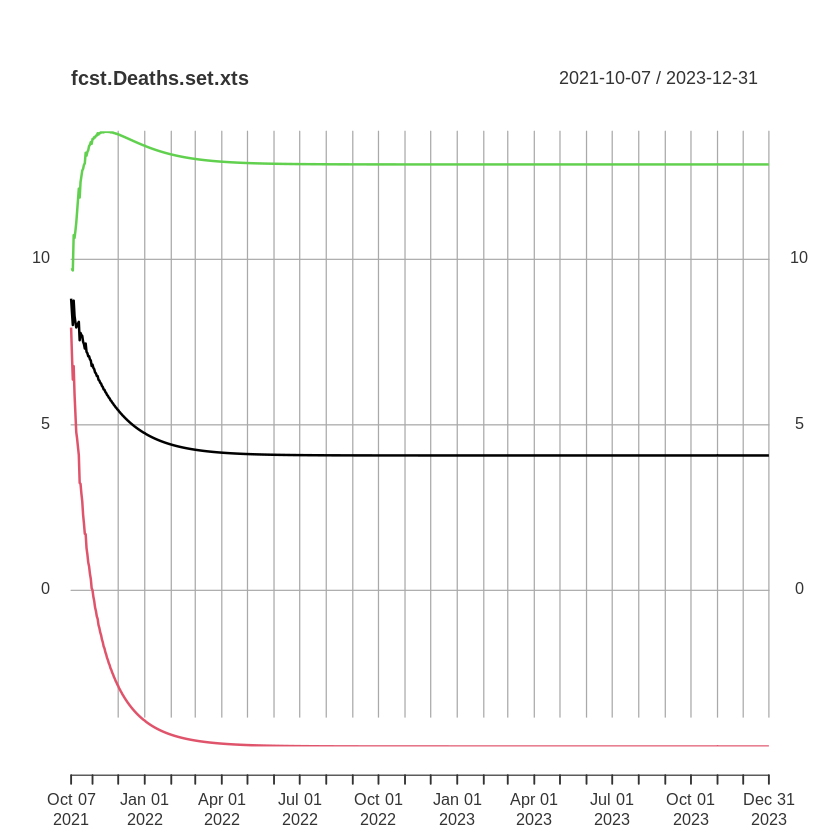

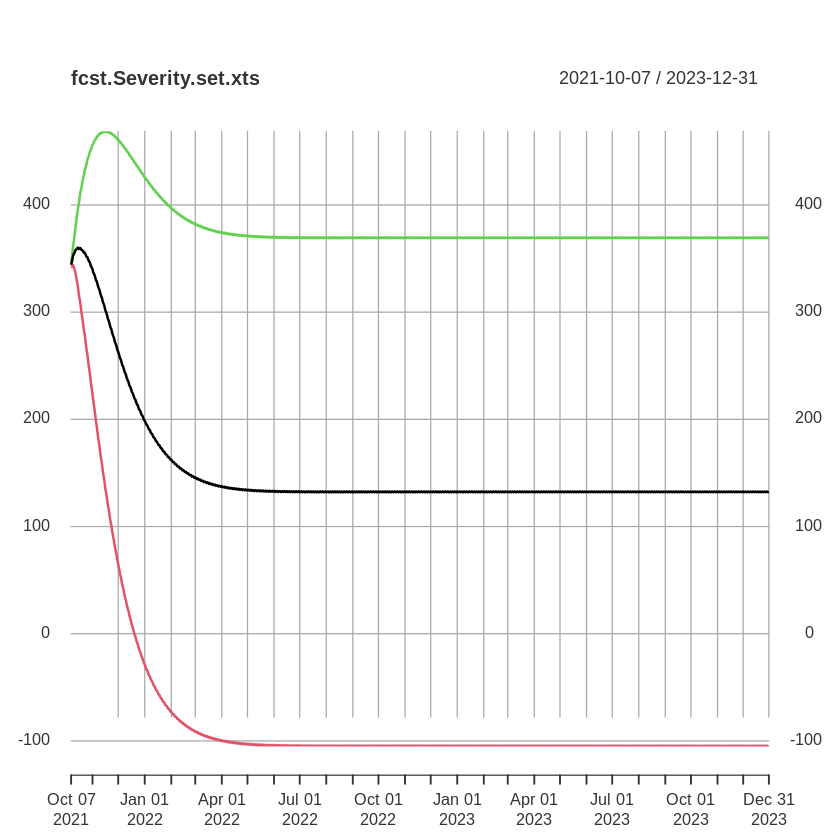

In [2]:
## AR-X estimation ------------------------------------------------------------------------------

x.xts.est <- x.xts[7:size.T,] 
y.xts.est <- y.xts[7:size.T,]
wd.xts.est <- wd.xts[7:size.T,]
OX.xts.est <- OX.xts[7:size.T,]

VAR.exogen <- cbind(OX.xts.est)

# Lag selection (including x into the VAR)
VAR.xts.est <- cbind(y.xts.est,x.xts.est)
VAR.select <- VARselect(VAR.xts.est, lag.max = 10,type = "const",exogen =VAR.exogen) # Lag selection
opt.p1 <- VAR.select$selection[1] # the opt.p (= optimal p) is determind by the AIC in VAR.select

x.xts.exg <- x.xts
x.xts.exg.est <- x.xts.exg[7:size.T,]

AR.exog <- cbind(x.xts.exg.est,OX.xts.est)

AR.est <- arima(y.xts.est, order = c(opt.p1,0,0),xreg = AR.exog, include.mean = TRUE, method = "ML")

## Forecasting with AR-X ------------------------------------------------------------------------

x.xts.fcst <- x.xts.exg[(size.T+1):(size.T+size.H),]
wd.xts.fcst <- wd.xts[(size.T+1):(size.T+size.H),]
OX.xts.fcst <- OX.xts[(size.T+1):(size.T+size.H),]

fcst.exog <- cbind(x.xts.fcst,OX.xts.fcst)

y.fcst <- predict(AR.est, n.ahead = size.H, ci = 0.95, newxreg = fcst.exog)

fcst.y.pt <- y.fcst$pred
fcst.y.se <- y.fcst$se
fcst.y.95upp <- fcst.y.pt+1.96*fcst.y.se
fcst.y.95low <- fcst.y.pt-1.96*fcst.y.se

fcst.y.set <- as.data.frame(cbind(fcst.y.pt,fcst.y.95low,fcst.y.95upp))
fcst.Confirmed.set.xts <- as.xts(fcst.y.set,order.by=date.fcst)

plot.xts(fcst.Confirmed.set.xts,plot.type = "single")

##---------------------------------------------------------------------------------------------------

# select the endogenous variables in y
y.df <- select(df,Deaths.MA7)
y.xts <- as.xts(y.df, order.by = date.data)

# select the exogenous variables in x
x.df <- select(df,VM_alpha,VM_delta,d_Vaccine)
x.xts <- as.xts(x.df, order.by = date.data)

# select weekday dummies (excluding Sunday)
wd.df <- select(df,dd.Mon,dd.Tue,dd.Wed,dd.Thu,dd.Fri,dd.Sat)
wd.xts <- as.xts(wd.df, order.by = date.data)

# select social distance varaible
OX.df <- select(df,Ox)
OX.xts <- as.xts(OX.df, order.by = date.data)


# sample size and forecasting window
size.H <- length(date.fcst)         # forecasting window: in this case, the length of future values in x
size.T <- length(date.data)-size.H  # sample size for estimation

n <- ncol(y.df) # Number of endogenous variables (y) 
k <- ncol(x.df) # Number of exogenous variables (x) 

## AR-X estimation ------------------------------------------------------------------------------

x.xts.est <- x.xts[7:size.T,] 
y.xts.est <- y.xts[7:size.T,]
wd.xts.est <- wd.xts[7:size.T,]
OX.xts.est <- OX.xts[7:size.T,]

VAR.exogen <- cbind(OX.xts.est)

# Lag selection (including x into the VAR)
VAR.xts.est <- cbind(y.xts.est,x.xts.est)
VAR.select <- VARselect(VAR.xts.est, lag.max = 10,type = "const",exogen =VAR.exogen) # Lag selection
opt.p2 <- VAR.select$selection[1] # the opt.p (= optimal p) is determind by the AIC in VAR.select

x.xts.exg <- x.xts
x.xts.exg.est <- x.xts.exg[7:size.T,]

AR.exog <- cbind(x.xts.exg.est,OX.xts.est)

AR.est <- arima(y.xts.est, order = c(opt.p2,0,0),xreg = AR.exog, include.mean = TRUE, method = "ML")

## Forecasting with AR-X ------------------------------------------------------------------------

x.xts.fcst <- x.xts.exg[(size.T+1):(size.T+size.H),]
wd.xts.fcst <- wd.xts[(size.T+1):(size.T+size.H),]
OX.xts.fcst <- OX.xts[(size.T+1):(size.T+size.H),]

fcst.exog <- cbind(x.xts.fcst,OX.xts.fcst)

y.fcst <- predict(AR.est, n.ahead = size.H, ci = 0.95, newxreg = fcst.exog)

fcst.y.pt <- y.fcst$pred
fcst.y.se <- y.fcst$se
fcst.y.95upp <- fcst.y.pt+1.96*fcst.y.se
fcst.y.95low <- fcst.y.pt-1.96*fcst.y.se

fcst.y.set <- as.data.frame(cbind(fcst.y.pt,fcst.y.95low,fcst.y.95upp))
fcst.Deaths.set.xts <- as.xts(fcst.y.set,order.by=date.fcst)

plot.xts(fcst.Deaths.set.xts,plot.type = "single")

##-------------------------------------------------------------------------------------------------
# select the endogenous variables in y
y.df <- select(df,Severity.MA7)
y.xts <- as.xts(y.df, order.by = date.data)

# select the exogenous variables in x
x.df <- select(df,VM_alpha,VM_delta,d_Vaccine)
x.xts <- as.xts(x.df, order.by = date.data)

# select weekday dummies (excluding Sunday)
wd.df <- select(df,dd.Mon,dd.Tue,dd.Wed,dd.Thu,dd.Fri,dd.Sat)
wd.xts <- as.xts(wd.df, order.by = date.data)

# select social distance varaible
OX.df <- select(df,Ox)
OX.xts <- as.xts(OX.df, order.by = date.data)


# sample size and forecasting window
size.H <- length(date.fcst)         # forecasting window: in this case, the length of future values in x
size.T <- length(date.data)-size.H  # sample size for estimation

n <- ncol(y.df) # Number of endogenous variables (y) 
k <- ncol(x.df) # Number of exogenous variables (x) 

## AR-X estimation ------------------------------------------------------------------------------

x.xts.est <- x.xts[7:size.T,] 
y.xts.est <- y.xts[7:size.T,]
wd.xts.est <- wd.xts[7:size.T,]
OX.xts.est <- OX.xts[7:size.T,]

VAR.exogen <- cbind(OX.xts.est)

# Lag selection (including x into the VAR)
VAR.xts.est <- cbind(y.xts.est,x.xts.est)
VAR.select <- VARselect(VAR.xts.est, lag.max = 10,type = "const",exogen =VAR.exogen) # Lag selection
opt.p3 <- VAR.select$selection[1] # the opt.p (= optimal p) is determind by the AIC in VAR.select

x.xts.exg <- x.xts
x.xts.exg.est <- x.xts.exg[7:size.T,]

AR.exog <- cbind(x.xts.exg.est,OX.xts.est)

AR.est <- arima(y.xts.est, order = c(opt.p3,0,2),xreg = AR.exog, include.mean = TRUE, method = "ML")

## Forecasting with AR-X ------------------------------------------------------------------------

x.xts.fcst <- x.xts.exg[(size.T+1):(size.T+size.H),]
wd.xts.fcst <- wd.xts[(size.T+1):(size.T+size.H),]
OX.xts.fcst <- OX.xts[(size.T+1):(size.T+size.H),]

fcst.exog <- cbind(x.xts.fcst,OX.xts.fcst)

y.fcst <- predict(AR.est, n.ahead = size.H, ci = 0.95, newxreg = fcst.exog)

fcst.y.pt <- y.fcst$pred
fcst.y.se <- y.fcst$se
fcst.y.95upp <- fcst.y.pt+1.96*fcst.y.se
fcst.y.95low <- fcst.y.pt-1.96*fcst.y.se

fcst.y.set <- as.data.frame(cbind(fcst.y.pt,fcst.y.95low,fcst.y.95upp))
fcst.Severity.set.xts <- as.xts(fcst.y.set,order.by=date.fcst)

plot.xts(fcst.Severity.set.xts,plot.type = "single")





In [4]:
################ PLOT 1 ##################################

#### Re-reading data from raw data
Date <- strftime(df$Date, format = "%Y-%m-%d") 
Confirmed <- df$Confirmed
raw.df <-data.frame(Date, Confirmed)   ### Bring past dataset
raw.df$Date <- seq(ymd("2020-01-22"), ymd("2023-12-31"), by="day")

fcst.Confirmed.set.xts <- as.data.frame(fcst.Confirmed.set.xts)
fcst.Confirmed.set.xts$Date <- seq(ymd("2021-10-07"), ymd("2023-12-31"), by="day") ### Bring forecasting dataset

forecast <- full_join(raw.df, fcst.Confirmed.set.xts, by = 'Date')
names(forecast)
names(forecast) <- c("Date", "Confirmed", "PointForecast", "Lo95", "Hi95")
write.csv(forecast,file='../../../../03_result/SWAR/211102/swar_211102_i_test.csv')

# #### Plot function
# drawplot <- function(forecast, title)
# {
#   names(forecast) <- gsub(" ", "", names(forecast))
  
#   ggplot(data = forecast, aes(x = Date)) +
#     geom_ribbon(data = forecast, aes(ymin = Lo95, ymax = Hi95), fill = "lightblue", alpha = 0.4,
#                 linetype = 0) + # 95% CI
#     geom_line(data = forecast[which(forecast$Date >= "2021-09-28"), ], 
#               aes(y = as.numeric(PointForecast)), colour = "royalblue", size = 1) + # Forecast
#     geom_line(data = raw2[which(raw2$Date <= ymd("2021-09-27")), ], aes(y = Confirmed)) + # Past
#     scale_y_continuous(name="COVID-19(Count)", limit =c(0, 5000)) +
#     scale_x_date(breaks = "6 month", date_labels = "%Y-%m") +
#     ggtitle(title) +
#     xlab("Date") + ylab("COVID-19(Count)") +
#     theme_minimal() +
#     theme(
#       axis.text.x = element_text(angle = 45, hjust = 1),
#       axis.text = element_text(size = 10),
#       axis.title = element_text(size = 11),
#       legend.text = element_text(size = 12)) +
#     theme(plot.margin = unit(c(0,1.5,1.5,1.5), "lines"))
# }
# raw2 <- raw.df %>% 
#   tibble() %>% 
#   mutate(Date = ymd(Date))

# a <- drawplot(forecast %>% tibble() %>% mutate(Date = ymd(Date)), "Newly reported cases")
# plot1 <- a +
#   geom_vline(xintercept = as.numeric(as.Date("2021-09-28")), linetype = "dotted", size = 1.2, color = "red")
# plot1





[1] "Date"         "Confirmed"    "fcst.y.pt"    "fcst.y.95low" "fcst.y.95upp"

In [5]:
################ PLOT 2 ##################################

#### Re-reading data from raw data
Date <- strftime(df$Date, format = "%Y-%m-%d") 
Severity <- df$Severity
raw.df <-data.frame(Date, Severity)   ### Bring past dataset
raw.df$Date <- seq(ymd("2020-01-22"), ymd("2023-12-31"), by="day")

fcst.Severity.set.xts <- as.data.frame(fcst.Severity.set.xts)
fcst.Severity.set.xts$Date <- seq(ymd("2021-10-07"), ymd("2023-12-31"), by="day") ### Bring forecasting dataset

forecast <- full_join(raw.df, fcst.Severity.set.xts, by = 'Date')
names(forecast)
names(forecast) <- c("Date", "Severity", "PointForecast", "Lo95", "Hi95")
write.csv(forecast,file='../../../../03_result/SWAR/211102/swar_211102_s_test.csv')

# #### Plot function
# drawplot <- function(forecast, title)
# {
#   names(forecast) <- gsub(" ", "", names(forecast))
  
#   ggplot(data = forecast, aes(x = Date)) +
#     geom_ribbon(data = forecast, aes(ymin = Lo95, ymax = Hi95), fill = "lightblue", alpha = 0.4,
#                 linetype = 0) + # 95% CI
#     geom_line(data = forecast[which(forecast$Date >= "2021-10-07"), ], 
#               aes(y = as.numeric(PointForecast)), colour = "royalblue", size = 1) + # Forecast
#     geom_line(data = raw2[which(raw2$Date <= ymd("2021-10-06")), ], aes(y = Severity)) + # Past
#     scale_y_continuous(name="COVID-19(Count)", limit =c(0, 500)) +
#     scale_x_date(breaks = "6 month", date_labels = "%Y-%m") +
#     ggtitle(title) +
#     xlab("Date") + ylab("COVID-19(Count)") +
#     theme_minimal() +
#     theme(
#       axis.text.x = element_text(angle = 45, hjust = 1),
#       axis.text = element_text(size = 10),
#       axis.title = element_text(size = 11),
#       legend.text = element_text(size = 12)) +
#     theme(plot.margin = unit(c(0,1.5,1.5,1.5), "lines"))
# }
# raw2 <- raw.df %>% 
#   tibble() %>% 
#   mutate(Date = ymd(Date))

# b <- drawplot(forecast %>% tibble() %>% mutate(Date = ymd(Date)), "Prevalence of severe cases")
# plot2 <- b +
#   geom_vline(xintercept = as.numeric(as.Date("2021-09-28")), linetype = "dotted", size = 1.2, color = "red")
# plot2



[1] "Date"         "Severity"     "fcst.y.pt"    "fcst.y.95low" "fcst.y.95upp"

In [6]:

################ PLOT 3 ##################################

#### Re-reading data from raw data
Date <- strftime(df$Date, format = "%Y-%m-%d") 
Deaths <- df$Deaths
raw.df <-data.frame(Date, Deaths)   ### Bring past dataset
raw.df$Date <- seq(ymd("2020-01-22"), ymd("2023-12-31"), by="day")

fcst.Deaths.set.xts <- as.data.frame(fcst.Deaths.set.xts)
fcst.Deaths.set.xts$Date <- seq(ymd("2021-10-07"), ymd("2023-12-31"), by="day") ### Bring forecasting dataset

forecast <- full_join(raw.df, fcst.Deaths.set.xts, by = 'Date')
names(forecast)
names(forecast) <- c("Date", "Deaths", "PointForecast", "Lo95", "Hi95")
write.csv(forecast,file='../../../../03_result/SWAR/211102/swar_211102_d_test.csv')

# #### Plot function
# drawplot <- function(forecast, title)
# {
#   names(forecast) <- gsub(" ", "", names(forecast))
  
#   ggplot(data = forecast, aes(x = Date)) +
#     geom_ribbon(data = forecast, aes(ymin = Lo95, ymax = Hi95), fill = "lightblue", alpha = 0.4,
#                 linetype = 0) + # 95% CI
#     geom_line(data = forecast[which(forecast$Date >= "2021-09-28"), ], 
#               aes(y = as.numeric(PointForecast)), colour = "royalblue", size = 1) + # Forecast
#     geom_line(data = raw2[which(raw2$Date <= ymd("2021-09-27")), ], aes(y = Deaths)) + # Past
#     scale_y_continuous(name="COVID-19(Count)", limit =c(0, 30)) +
#     scale_x_date(breaks = "6 month", date_labels = "%Y-%m") +
#     ggtitle(title) +
#     xlab("Date") + ylab("COVID-19(Count)") +
#     theme_minimal() +
#     theme(
#       axis.text.x = element_text(angle = 45, hjust = 1),
#       axis.text = element_text(size = 10),
#       axis.title = element_text(size = 11),
#       legend.text = element_text(size = 12)) +
#     theme(plot.margin = unit(c(0,1.5,1.5,1.5), "lines"))
# }
# raw2 <- raw.df %>% 
#   tibble() %>% 
#   mutate(Date = ymd(Date))

# c <- drawplot(forecast %>% tibble() %>% mutate(Date = ymd(Date)), "Deaths")
# plot3 <- c +
#   geom_vline(xintercept = as.numeric(as.Date("2021-09-28")), linetype = "dotted", size = 1.2, color = "red")
# plot3


# ### Combine plots
# plot_all <- ggarrange(plot1, plot2, plot3, 
#                       labels = c("A", "B", "C"),
#                       ncol = 3, nrow = 1)

# # ggsave("F:/Hong_COVID/AI/SWARX_Nov.jpg", plot_all, width = 12, height = 4)

[1] "Date"         "Deaths"       "fcst.y.pt"    "fcst.y.95low" "fcst.y.95upp"